### Import libraries

In [1]:
import pandas as pd 
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import datetime as dt
import warnings

warnings.filterwarnings(action='ignore')

### Load datasets

In [2]:
# load tracks and filter out songs released before 2022
tracks = pd.read_excel('Data/tracks.xlsx')
tracks = tracks[tracks['release_date']>='2022-01-01'].reset_index(drop=True)

# load audio features and artist_info
audio_features = pd.read_excel('Data/audio_features.xlsx')
artist_info = pd.read_excel('Data/artist_info.xlsx')

In [3]:
# preview of tracks
tracks.head()

,track_id,track_name,artist_id,artist_name,explicit,release_date,popularity
0,1bDbXMyjaUIooNwFE9wn0N,Rich Flex,3TVXtAsR1Inumwj472S9r4,Drake,1,2022-11-04,96
1,3F5CgOj3wFlRv51JsHbxhe,Jimmy Cooks (feat. 21 Savage),3TVXtAsR1Inumwj472S9r4,Drake,1,2022-06-17,90
2,2KLwPaRDOB87XOYAT2fgxh,Pussy & Millions (feat. Travis Scott),3TVXtAsR1Inumwj472S9r4,Drake,1,2022-11-04,89
3,46s57QULU02Voy0Kup6UEb,Major Distribution,3TVXtAsR1Inumwj472S9r4,Drake,1,2022-11-04,88
4,34tz0eDhGuFErIuW3q4mPX,On BS,3TVXtAsR1Inumwj472S9r4,Drake,1,2022-11-04,88


In [4]:
# number of missing values in each feature
tracks.isnull().sum()

track_id        0
track_name      0
artist_id       0
artist_name     0
explicit        0
release_date    0
popularity      0
dtype: int64

In [5]:
# preview of audio features 
audio_features.head()

,track_id,audio_features
0,1bDbXMyjaUIooNwFE9wn0N,"{'danceability': 0.561, 'energy': 0.52, 'key':..."
1,3F5CgOj3wFlRv51JsHbxhe,"{'danceability': 0.529, 'energy': 0.673, 'key'..."
2,2KLwPaRDOB87XOYAT2fgxh,"{'danceability': 0.749, 'energy': 0.63, 'key':..."
3,46s57QULU02Voy0Kup6UEb,"{'danceability': 0.908, 'energy': 0.546, 'key'..."
4,34tz0eDhGuFErIuW3q4mPX,"{'danceability': 0.841, 'energy': 0.358, 'key'..."


In [6]:
# number of missing values in each feature
audio_features.isnull().sum()

track_id            0
audio_features    438
dtype: int64

In [7]:
artist_info.head()

,artist,artist_info
0,Drake,{'external_urls': {'spotify': 'https://open.sp...
1,Bad Bunny,{'external_urls': {'spotify': 'https://open.sp...
2,Ed Sheeran,{'external_urls': {'spotify': 'https://open.sp...
3,Taylor Swift,{'external_urls': {'spotify': 'https://open.sp...
4,The Weeknd,{'external_urls': {'spotify': 'https://open.sp...


In [8]:
# number of missing values in each feature

artist_info.isnull().sum()

artist         0
artist_info    0
dtype: int64

### Preprocessing

#### Extract audio features

In [9]:
# remove tracks without audio features
audio_features = audio_features.dropna()

In [10]:
# extract relevant audio feature metrics from the dictionary and store them in separate columns
audio_features['audio_features_dict'] = audio_features['audio_features'].apply(lambda x: ast.literal_eval(x))
audio_features['danceability'] = audio_features['audio_features_dict'].apply(lambda x: x['danceability'])
audio_features['energy'] = audio_features['audio_features_dict'].apply(lambda x: x['energy'])
audio_features['key'] = audio_features['audio_features_dict'].apply(lambda x: x['key'])
audio_features['loudness'] = audio_features['audio_features_dict'].apply(lambda x: x['loudness'])
audio_features['mode'] = audio_features['audio_features_dict'].apply(lambda x: x['mode'])
audio_features['speechiness'] = audio_features['audio_features_dict'].apply(lambda x: x['speechiness'])
audio_features['acousticness'] = audio_features['audio_features_dict'].apply(lambda x: x['acousticness'])
audio_features['instrumentalness'] = audio_features['audio_features_dict'].apply(lambda x: x['instrumentalness'])
audio_features['liveness'] = audio_features['audio_features_dict'].apply(lambda x: x['liveness'])
audio_features['valence'] = audio_features['audio_features_dict'].apply(lambda x: x['valence'])
audio_features['duration_ms'] = audio_features['audio_features_dict'].apply(lambda x: x['duration_ms'])
audio_features['time_signature'] = audio_features['audio_features_dict'].apply(lambda x: x['time_signature'])
audio_features = audio_features.drop(['audio_features', 'audio_features_dict'], axis=1)

#### Extract artist info 

In [11]:
# extract relevant artist info metrics from the dictionary and store them in separate columns

artist_info['artist_info_dict'] = artist_info['artist_info'].apply(lambda x: ast.literal_eval(x))
artist_info['followers'] = artist_info['artist_info_dict'].apply(lambda x: x['followers']['total'])
artist_info['genres'] = artist_info['artist_info_dict'].apply(lambda x: x['genres'])
artist_info = artist_info.drop(['artist_info', 'artist_info_dict'], axis=1)

### Join datasets

In [12]:
# join three datasets
df = tracks.merge(audio_features, how='left', on='track_id')
df = df.merge(artist_info, how='left', left_on='artist_name', right_on='artist')
df.head()

,track_id,track_name,artist_id,artist_name,explicit,release_date,popularity,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,time_signature,artist,followers,genres
0,1bDbXMyjaUIooNwFE9wn0N,Rich Flex,3TVXtAsR1Inumwj472S9r4,Drake,1,2022-11-04,96,0.561,0.520,11.0,...,0.244,0.050300,0.000002,0.3550,0.424,239360.0,3.0,Drake,70260570,"[canadian hip hop, canadian pop, hip hop, rap,..."
1,3F5CgOj3wFlRv51JsHbxhe,Jimmy Cooks (feat. 21 Savage),3TVXtAsR1Inumwj472S9r4,Drake,1,2022-06-17,90,0.529,0.673,0.0,...,0.175,0.000307,0.000002,0.0930,0.366,218365.0,4.0,Drake,70260570,"[canadian hip hop, canadian pop, hip hop, rap,..."
2,2KLwPaRDOB87XOYAT2fgxh,Pussy & Millions (feat. Travis Scott),3TVXtAsR1Inumwj472S9r4,Drake,1,2022-11-04,89,0.749,0.630,4.0,...,0.116,0.062300,0.000000,0.3530,0.445,242027.0,4.0,Drake,70260570,"[canadian hip hop, canadian pop, hip hop, rap,..."
3,46s57QULU02Voy0Kup6UEb,Major Distribution,3TVXtAsR1Inumwj472S9r4,Drake,1,2022-11-04,88,0.908,0.546,8.0,...,0.323,0.012700,0.000000,0.0707,0.225,170502.0,4.0,Drake,70260570,"[canadian hip hop, canadian pop, hip hop, rap,..."
4,34tz0eDhGuFErIuW3q4mPX,On BS,3TVXtAsR1Inumwj472S9r4,Drake,1,2022-11-04,88,0.841,0.358,9.0,...,0.591,0.020100,0.000000,0.3900,0.329,261544.0,4.0,Drake,70260570,"[canadian hip hop, canadian pop, hip hop, rap,..."


In [13]:
df.shape

(101700, 22)

### Exploratory Data Analysis

In [14]:
# search for missing values after joining datasets
df.isnull().sum()

track_id              0
track_name            0
artist_id             0
artist_name           0
explicit              0
release_date          0
popularity            0
danceability        159
energy              159
key                 159
loudness            159
mode                159
speechiness         159
acousticness        159
instrumentalness    159
liveness            159
valence             159
duration_ms         159
time_signature      159
artist                0
followers             0
genres                0
dtype: int64

In [15]:
# drop songs without audio features
df = df.dropna()

In [16]:
# search for duplicate tracks
duplicates = df[df['track_id'].duplicated()]['track_id']
print(f'There are {len(duplicates)} duplicate songs.')

There are 2613 duplicate songs.


In [17]:
# remove duplicates
df = df.drop_duplicates('track_id', keep='first')

### Examine target feature 

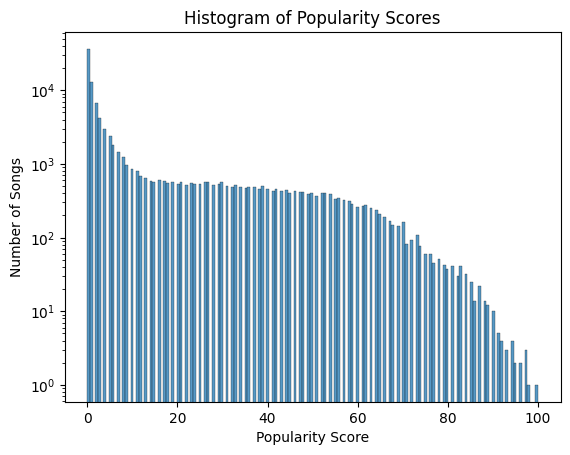

In [18]:
# plot the distribution of target feature
ax = sns.histplot(df['popularity'])
ax.set_yscale('log')
ax.set(xlabel='Popularity Score', ylabel='Number of Songs')
plt.title('Histogram of Popularity Scores')
plt.show()

### Examine predictive features

In [19]:
# find the number of unique sub genre combinations
genres_df = df.drop_duplicates('artist_name', keep='first')
#print(len(genres_df['genres'].unique()))
all_subgenres = []
for list_genres in genres_df['genres']:
    all_subgenres.extend(list_genres)
    
count_subgenres = Counter(all_subgenres)
print(f'There are {len(count_subgenres)} unique subgenres')

There are 604 unique subgenres


In [20]:
# consolidate sub-genres into main genres
main_genres = ['hip-hop/rap', 'pop', 'rock', 'latin', 'metal', 'edm', 'r&b', 'country', 'classical']


def find_main_genres(list_subgenres):
    """derive the main genre of a given artist based on their provided subgenres"""
    str_sub_genres = " ".join(list_subgenres)
    
    genre_conversion = {
        'hip hop': 'hip-hop/rap',
        'rap': 'hip-hop/rap',
        'pop': 'pop',
        'rock': 'rock',
        'metal': 'metal',
        'edm': 'edm',
        'house': 'edm',
        'county': 'county',
        'classical': 'classical',
        'latino': 'latino'
    }
    
    # convert sub-genres to list of genres
    main_genres = []
    for genre in genre_conversion:
        if genre in str_sub_genres:
            main_genres.append(genre_conversion[genre])
    
    # select the most common genre in the list of genres
    if len(main_genres) == 0:
        
        # return other if no main genre is found
        return 'other'
    else:
        
        # return the most frequent genre
        genre_count = Counter(main_genres)
        return genre_count.most_common(1)[0][0]

In [21]:
# find the main genres of each track
df['main_genre'] = df['genres'].apply(lambda x: find_main_genres(x))

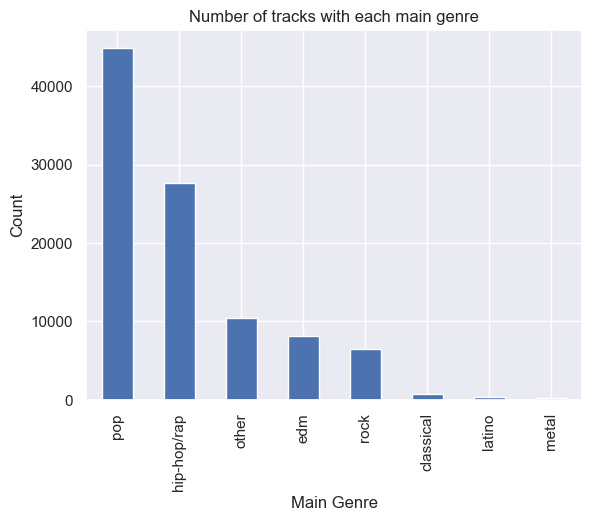

In [22]:
# plot the number of tracks with each genre
sns.set()
df['main_genre'].value_counts().plot.bar()
plt.xlabel('Main Genre')
plt.ylabel('Count')
plt.title('Number of tracks with each main genre')
plt.show()

In [23]:
def pop_or_rap(subgenres):
    """Determines whether or not a song is pop and/or rap based on the given subgenres"""
    rap_or_pop = []
    for subgenre in subgenres:
        if 'hip hop' in subgenre or 'rap' in subgenre or 'pop' in subgenre:
            return 1
        return 0
        
# turn genre into a binary variable
df['is_pop_or_rap'] = df['genres'].apply(lambda x: pop_or_rap(x))

In [24]:
# drop genre features
df = df.drop(['genres', 'main_genre'], axis=1)

In [25]:
# search for missing values in is_pop_or_rap feauture
df[df['is_pop_or_rap'].isnull()][['track_id', 'is_pop_or_rap']].head()

,track_id,is_pop_or_rap
76338,4Fd2jLQspwZVv7hF3bXHFg,NaN
76339,49gy4VLiaUupmf4WMqt4vm,NaN
76340,7jI5gFdBX8ZzxW1dYikMvs,NaN
76341,1XbNa4RJHTjjEvzyPmZpRD,NaN
76342,5Sais3rpCiDlsL7b1aNQeS,NaN


In [26]:
# identify artist(s) with missing values
df[df['is_pop_or_rap'].isnull()]['artist_name'].value_counts()

NEFFEX    260
Name: artist_name, dtype: int64

In [27]:
# fill missing values
df['is_pop_or_rap'] = df['is_pop_or_rap'].fillna(1)

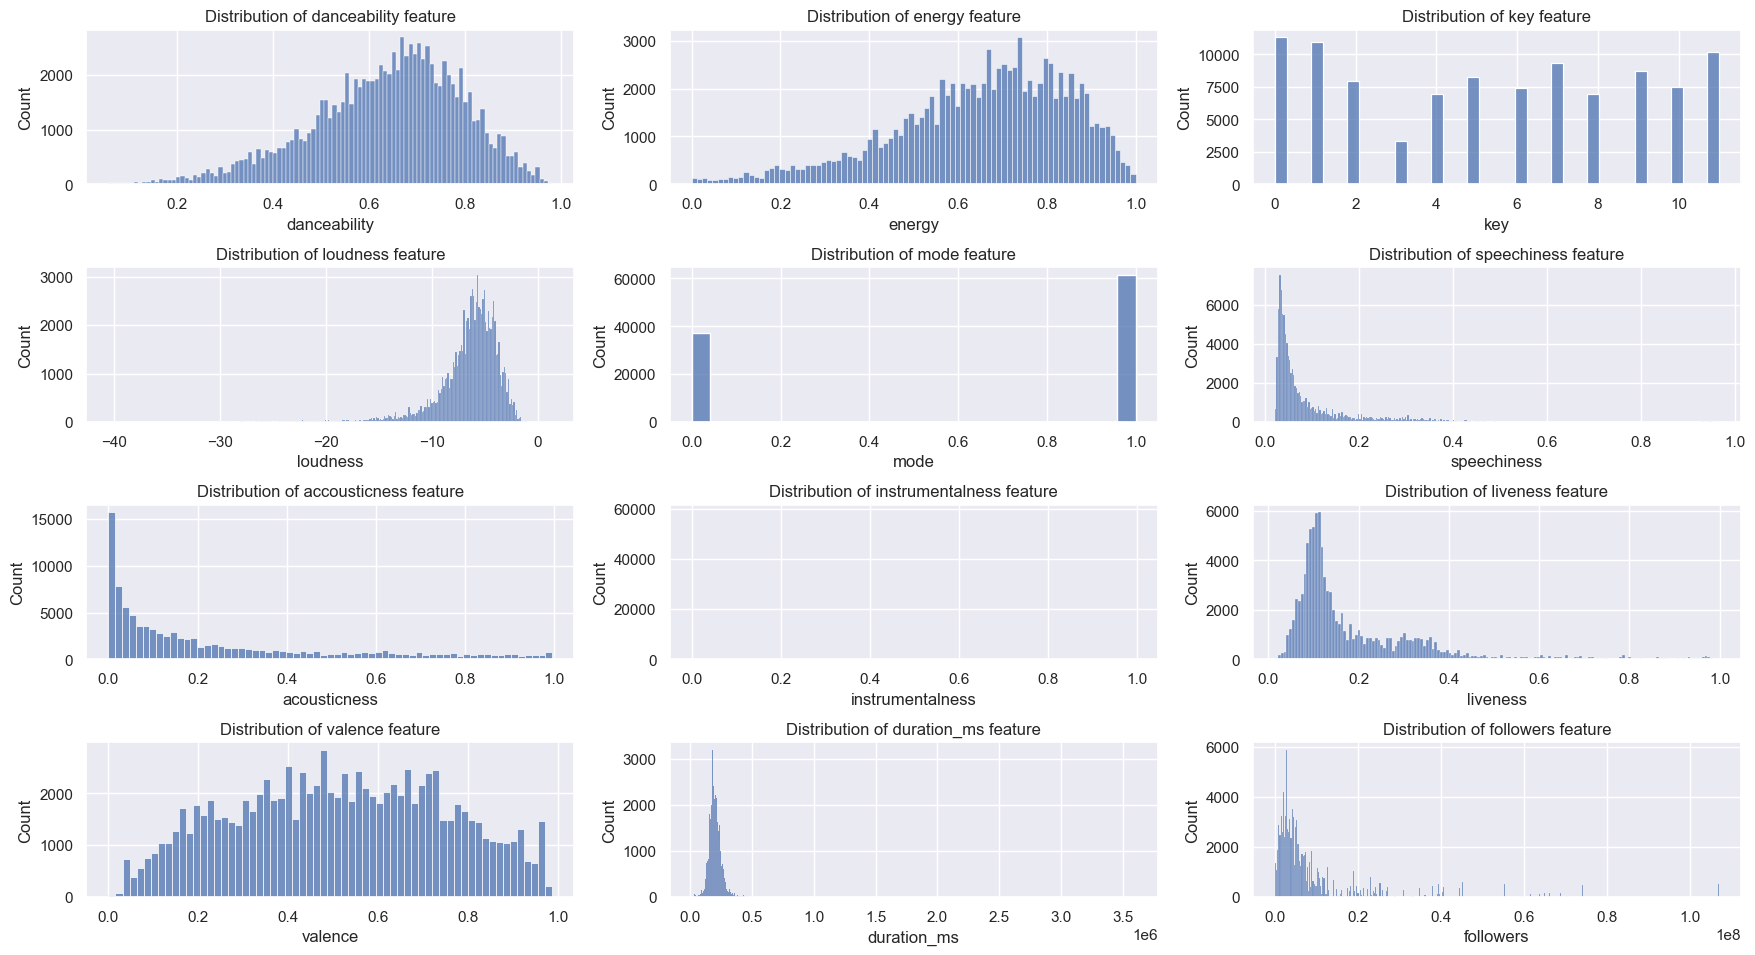

In [28]:
# plot the distribution of audio features with histogram
sns.set()
fig, axes = plt.subplots(4, 3, figsize=(18, 10))
fig.tight_layout(pad=3.0)

sns.histplot(ax=axes[0, 0], data=df, x='danceability')
sns.histplot(ax=axes[0, 1], data=df, x='energy')
sns.histplot(ax=axes[0, 2], data=df, x='key')
sns.histplot(ax=axes[1, 0], data=df, x='loudness')
sns.histplot(ax=axes[1, 1], data=df, x='mode')
sns.histplot(ax=axes[1, 2], data=df, x='speechiness')
sns.histplot(ax=axes[2, 0], data=df, x='acousticness')
sns.histplot(ax=axes[2, 1], data=df, x='instrumentalness')
sns.histplot(ax=axes[2, 2], data=df, x='liveness')
sns.histplot(ax=axes[3, 0], data=df, x='valence')
sns.histplot(ax=axes[3, 1], data=df, x='duration_ms')
sns.histplot(ax=axes[3, 2], data=df, x='followers')

axes[0, 0].title.set_text('Distribution of danceability feature')
axes[0, 1].title.set_text('Distribution of energy feature')
axes[0, 2].title.set_text('Distribution of key feature')
axes[1, 0].title.set_text('Distribution of loudness feature')
axes[1, 1].title.set_text('Distribution of mode feature')
axes[1, 2].title.set_text('Distribution of speechiness feature')
axes[2, 0].title.set_text('Distribution of accousticness feature')
axes[2, 1].title.set_text('Distribution of instrumentalness feature')
axes[2, 2].title.set_text('Distribution of liveness feature')
axes[3, 0].title.set_text('Distribution of valence feature')
axes[3, 1].title.set_text('Distribution of duration_ms feature')
axes[3, 2].title.set_text('Distribution of followers feature')

### Deriving time since release

In [29]:
# find the number of months that elapsed since the release of the songs
df['months_since_release'] = 12 - pd.DatetimeIndex(df['release_date']).month
df = df.drop('release_date', axis=1)

In [30]:
# convert song duration units from ms to s
df['duration_s'] = df['duration_ms'].apply(lambda x: x/1000)
df = df.drop('duration_ms', axis=1)

### Identifying features contributing to multicolinearity

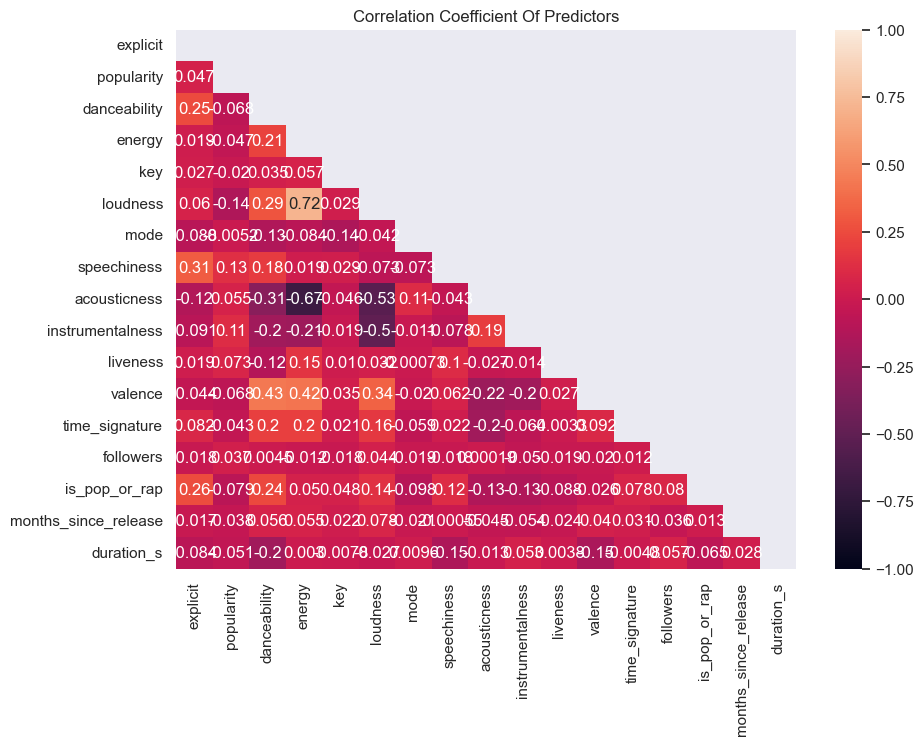

In [31]:
# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [32]:
def compute_vif(df:pd.DataFrame, considered_features:list)->pd.DataFrame:
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [33]:
# compute VIF for the audio features
considered_features = ['explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_s', 'time_signature', 'followers']
compute_vif(df=df, considered_features=considered_features)

,Variable,VIF
0,explicit,1.211034
1,danceability,1.596256
2,energy,3.478912
3,key,1.024001
4,loudness,3.060071
5,mode,1.053140
6,speechiness,1.214081
7,acousticness,2.031329
8,instrumentalness,1.486325
9,liveness,1.077065


### Key Takeaways from EDA

1. There are 159 records with missing audio features data, which need to be removed prior to modeling
2. There are 2613 duplicate songs, which need to be removed prior to modeling
3. The audio features all have skewed data distributions with outliers
4. There are 604 unique subgenres in the dataset, which need to be consolidated into fewer groups to avoid high dimensionality
5. The duration metric is currently reported in milliseconds and should be converted to seconds to be intuitive
6. All of the variables yielded a low variance inflation factor (i.e., less than 5), so there is little multicollinearity in the dataset

### Export processed data frame to .xlsx file

In [34]:
df.head()

,track_id,track_name,artist_id,artist_name,explicit,popularity,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,time_signature,artist,followers,is_pop_or_rap,months_since_release,duration_s
0,1bDbXMyjaUIooNwFE9wn0N,Rich Flex,3TVXtAsR1Inumwj472S9r4,Drake,1,96,0.561,0.520,11.0,-9.342,...,0.050300,0.000002,0.3550,0.424,3.0,Drake,70260570,1.0,1,239.360
1,3F5CgOj3wFlRv51JsHbxhe,Jimmy Cooks (feat. 21 Savage),3TVXtAsR1Inumwj472S9r4,Drake,1,90,0.529,0.673,0.0,-4.711,...,0.000307,0.000002,0.0930,0.366,4.0,Drake,70260570,1.0,6,218.365
2,2KLwPaRDOB87XOYAT2fgxh,Pussy & Millions (feat. Travis Scott),3TVXtAsR1Inumwj472S9r4,Drake,1,89,0.749,0.630,4.0,-6.652,...,0.062300,0.000000,0.3530,0.445,4.0,Drake,70260570,1.0,1,242.027
3,46s57QULU02Voy0Kup6UEb,Major Distribution,3TVXtAsR1Inumwj472S9r4,Drake,1,88,0.908,0.546,8.0,-10.491,...,0.012700,0.000000,0.0707,0.225,4.0,Drake,70260570,1.0,1,170.502
4,34tz0eDhGuFErIuW3q4mPX,On BS,3TVXtAsR1Inumwj472S9r4,Drake,1,88,0.841,0.358,9.0,-8.368,...,0.020100,0.000000,0.3900,0.329,4.0,Drake,70260570,1.0,1,261.544


In [35]:
# export dataset
df.to_excel('Data/Processed Data/model_data.xlsx', index=False)